In [89]:
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime, timedelta


In [741]:
df = pd.read_pickle("../data/raw/NNDSS.pkl")

In [742]:
df.head(4)

,states,year,week,label,m1_flag,m2,m2_flag,m3_flag,m4_flag,location2,sort_order,location1,geocode,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej,m4,m1,m3
0,US RESIDENTS,2022,1,Anthrax,-,0,-,-,-,US RESIDENTS,20220100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEW ENGLAND,2022,1,Anthrax,-,0,-,-,-,NEW ENGLAND,20220100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CONNECTICUT,2022,1,Anthrax,-,0,-,-,-,NaN,20220100003,CONNECTICUT,"{'type': 'Point', 'coordinates': [-72.738288, ...",24,1043,NaN,NaN,NaN
3,MAINE,2022,1,Anthrax,-,0,-,-,-,NaN,20220100004,MAINE,"{'type': 'Point', 'coordinates': [-69.06137, 4...",49,1725,NaN,NaN,NaN


In [743]:
df = df[['states','year','week','label','m1','location1']]
df.head()

,states,year,week,label,m1,location1
0,US RESIDENTS,2022,1,Anthrax,NaN,NaN
1,NEW ENGLAND,2022,1,Anthrax,NaN,NaN
2,CONNECTICUT,2022,1,Anthrax,NaN,CONNECTICUT
3,MAINE,2022,1,Anthrax,NaN,MAINE
4,MASSACHUSETTS,2022,1,Anthrax,NaN,MASSACHUSETTS


In [744]:
# ok, so in the csv, the year / week is just ['Current MMWR Year','MMWR WEEK'], and the number of cases (new cases) is "CUrrent week", Label is the disease.
# and similarly the api response, states	year	week	label	m1 (m1 is the current week number of new cases)
# states or reporting area contains more than states. regions, total, territories, US res, non-us res
# thought is to, create an outlier detection thing like in time series stuff I did for Live action. I think it's possible.
# https://dev.socrata.com/foundry/data.cdc.gov/x9gk-5huc

In [745]:
# now that I've download from API the data, it's better formatted. for no data it's actually NaN

In [746]:
df = df[df['location1'].notna()]

In [747]:
df = df.drop(columns='location1')

In [748]:
#df = df[['Reporting Area','Current MMWR Year','MMWR WEEK','Label','Current week']]
df.columns = ['state','year','week','label','new_cases']

In [749]:
df.head()

,state,year,week,label,new_cases
2,CONNECTICUT,2022,1,Anthrax,NaN
3,MAINE,2022,1,Anthrax,NaN
4,MASSACHUSETTS,2022,1,Anthrax,NaN
5,NEW HAMPSHIRE,2022,1,Anthrax,NaN
6,RHODE ISLAND,2022,1,Anthrax,NaN


In [750]:
df.tail()

,state,year,week,label,new_cases
871073,AMERICAN SAMOA,2024,8,"Zika virus disease, non-congenital",NaN
871074,NORTHERN MARIANA ISLANDS,2024,8,"Zika virus disease, non-congenital",NaN
871075,GUAM,2024,8,"Zika virus disease, non-congenital",NaN
871076,PUERTO RICO,2024,8,"Zika virus disease, non-congenital",NaN
871077,U.S. VIRGIN ISLANDS,2024,8,"Zika virus disease, non-congenital",NaN


In [751]:
# Ensure 'date' column is in the correct format and is sorted
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['week'].astype(str) + '-1', format='%Y-%W-%w')
# make unique id with state and label:
df['item_id'] = df['state'] + '_' + df['label']
df.sort_values(['item_id', 'date'], inplace=True)

In [752]:
df['new_cases'] = df.groupby('item_id')['new_cases'].transform(lambda x: x.ffill().bfill().fillna(0))

In [753]:
df['new_cases'] = df.new_cases.astype(int)

In [754]:
df.tail()

,state,year,week,label,new_cases,date,item_id
838305,WYOMING,2024,4,"Zika virus disease, non-congenital",0,2024-01-22,"WYOMING_Zika virus disease, non-congenital"
846495,WYOMING,2024,5,"Zika virus disease, non-congenital",0,2024-01-29,"WYOMING_Zika virus disease, non-congenital"
854685,WYOMING,2024,6,"Zika virus disease, non-congenital",0,2024-02-05,"WYOMING_Zika virus disease, non-congenital"
862875,WYOMING,2024,7,"Zika virus disease, non-congenital",0,2024-02-12,"WYOMING_Zika virus disease, non-congenital"
871065,WYOMING,2024,8,"Zika virus disease, non-congenital",0,2024-02-19,"WYOMING_Zika virus disease, non-congenital"


In [755]:
df['week'] = df.week.astype(int)
df['year'] = df.year.astype(int)

In [756]:
#df[(df.item_id=='WYOMING_Yellow fever') & (df.year==2023)].sort_values('date')[['year','week','item_id','date','new_cases']]

In [757]:
# Apply the function to fill missing weekly data
#df_filled = fill_weekly_gaps_loop(df)

# Verify the results
#print(df_filled[df_filled['item_id'] == 'WYOMING_Yellow fever'])

In [758]:
df = df[~df.label.str.contains("Probable")]

In [759]:
len(df)

672486

In [760]:
df.item_id.nunique()

6840

In [761]:
df[(df['state'] == 'WYOMING') & (df['label'] == 'Hepatitis C, perinatal infection')]

,state,year,week,label,new_cases,date,item_id
3135,WYOMING,2022,1,"Hepatitis C, perinatal infection",0,2022-01-03,"WYOMING_Hepatitis C, perinatal infection"
10835,WYOMING,2022,2,"Hepatitis C, perinatal infection",0,2022-01-10,"WYOMING_Hepatitis C, perinatal infection"
18535,WYOMING,2022,3,"Hepatitis C, perinatal infection",0,2022-01-17,"WYOMING_Hepatitis C, perinatal infection"
26235,WYOMING,2022,4,"Hepatitis C, perinatal infection",0,2022-01-24,"WYOMING_Hepatitis C, perinatal infection"
33935,WYOMING,2022,5,"Hepatitis C, perinatal infection",0,2022-01-31,"WYOMING_Hepatitis C, perinatal infection"
...,...,...,...,...,...,...,...
768865,WYOMING,2023,48,"Hepatitis C, perinatal infection",0,2023-11-27,"WYOMING_Hepatitis C, perinatal infection"
777125,WYOMING,2023,49,"Hepatitis C, perinatal infection",0,2023-12-04,"WYOMING_Hepatitis C, perinatal infection"
785175,WYOMING,2023,50,"Hepatitis C, perinatal infection",0,2023-12-11,"WYOMING_Hepatitis C, perinatal infection"
793085,WYOMING,2023,51,"Hepatitis C, perinatal infection",0,2023-12-18,"WYOMING_Hepatitis C, perinatal infection"


In [738]:
df[(df['state'] == 'WYOMING') & (df['label'] == 'Hepatitis C, perinatal infection')]

,state,year,week,label,new_cases,date,item_id


In [762]:
from itertools import product
from datetime import date
from tqdm import tqdm

def get_weeks_in_year(year):
    """Determine the number of ISO weeks in a given year."""
    last_day_of_year = date(year, 12, 28)  # ISO-8601; the week containing 28th Dec is the last week of the year
    return last_day_of_year.isocalendar()[1]

def fill_weekly_gaps(df):
    # Determine the maximum year and week present in the data for later use
    max_year = df['year'].max()
    max_week_for_max_year = df[df['year'] == max_year]['week'].max()

    all_combinations = []
    for item_id in tqdm(df['item_id'].unique(), desc='Filling gaps'):
        item_df = df[df['item_id'] == item_id]
        first_year = item_df['year'].min()
        last_year = item_df['year'].max()
        first_week = item_df[item_df['year'] == first_year]['week'].min()
        last_week = item_df[item_df['year'] == last_year]['week'].max()
        
        for year in df['year'].unique():
            if year < first_year or year > last_year:
                continue  # Skip years before the item_id first appears and after it last appears
            
            week_start = first_week if year == first_year else 1
            week_end = last_week if year == last_year else get_weeks_in_year(year)
            for week in range(week_start, week_end + 1):
                all_combinations.append({'item_id': item_id, 'year': year, 'week': week})
                
    all_combinations_df = pd.DataFrame(all_combinations)

    # Merge the generated combinations with the original DataFrame
    df_merged = pd.merge(all_combinations_df, df, on=['item_id', 'year', 'week'], how='left', indicator=True)
    
    # Carry forward the last observed 'new_cases', but only within the bounds of existing data for each item_id
    df_merged['new_cases'] = df_merged.groupby('item_id')['new_cases'].ffill().bfill()

    # Mark filled values for new_cases
    df_merged['filled_value'] = df_merged['_merge'] == 'left_only'
    df_merged.drop(columns=['_merge'], inplace=True)

    return df_merged

In [763]:
df = fill_weekly_gaps(df)

Filling gaps: 100%|██████████| 6840/6840 [10:37<00:00, 10.73it/s]


In [764]:
df.item_id.nunique()

6840

In [765]:
def year_week_to_date(year, week):
    """
    Convert a year and week number into the date of the Monday of that week.
    """
    # Calculate the first day of the year
    first_of_year = datetime(year, 1, 1)
    # ISO-8601 calculation for the first week of the year
    if first_of_year.weekday() > 3:  # If the first day is Friday or later
        # Move to the next Monday
        first_of_year += timedelta(days=7-first_of_year.weekday())
    else:
        # Move to the Monday of the current week
        first_of_year -= timedelta(days=first_of_year.weekday())
    
    # Calculate the Monday of the given week number
    week_start_date = first_of_year + timedelta(weeks=week-1)
    
    return week_start_date

# Assuming df is your DataFrame and it already contains 'year' and 'week' columns
# Update the 'date' column with the calculated Monday dates
df['date'] = df.apply(lambda row: year_week_to_date(int(row['year']), int(row['week'])), axis=1)


In [766]:
df['new_cases'] = df.new_cases.astype(int)

In [767]:
df.head()

,item_id,year,week,state,label,new_cases,date,filled_value
0,ALABAMA_Anthrax,2022,1,ALABAMA,Anthrax,0,2022-01-03,False
1,ALABAMA_Anthrax,2022,2,ALABAMA,Anthrax,0,2022-01-10,False
2,ALABAMA_Anthrax,2022,3,ALABAMA,Anthrax,0,2022-01-17,False
3,ALABAMA_Anthrax,2022,4,ALABAMA,Anthrax,0,2022-01-24,False
4,ALABAMA_Anthrax,2022,5,ALABAMA,Anthrax,0,2022-01-31,False


In [768]:
df[df.item_id=='WYOMING_Hepatitis C, chronic, Confirmed'].label.unique()

array(['Hepatitis C, chronic, Confirmed'], dtype=object)

In [769]:
df_mod = df[['item_id','date','label','new_cases']]

In [151]:
# so in short, i'm filling forward fillin in all dates (weeks of year) that aren't in the actual data but adding a flag to id that so if we later want to have a cumulative count
# we can ignore those rows

In [770]:
# Setting the cut-off date for the train-test split
# For example, if you want the last 4 weeks as your test set:
cut_off_date = df_mod['date'].max() - pd.Timedelta(weeks=10)

# Splitting the DataFrame into training and testing sets
train = df_mod[df_mod['date'] <= cut_off_date]
test = df_mod[df_mod['date'] > cut_off_date]

In [771]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.dataset.common import ListDataset

In [772]:
train_ds = PandasDataset.from_long_dataframe(train, target='new_cases', item_id='item_id', 
                                             timestamp='date', freq='W')
test_ds = PandasDataset.from_long_dataframe(test, target='new_cases', item_id='item_id', 
                                            timestamp='date', freq='W')

In [773]:
train_ds

PandasDataset<size=6555, freq=W, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [774]:
from gluonts.torch.distributions.negative_binomial import NegativeBinomialOutput

In [775]:
# Train the model and make predictions
estimator = DeepAREstimator(
    prediction_length=10,
    freq="W",
    distr_output=NegativeBinomialOutput(),
    trainer_kwargs={"max_epochs": 25}
)

model = estimator.train(train_ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.8 K | [[1, 1], [1, 1], [1, 166, 3], [1, 166], [1, 166], [1, 10, 3]] | [1, 100, 10]
---------------------------------------------------------------------------------------------------------------------
23.8 K    Trainable params
0         Non-trainable params
23.8 K    Total params
0.095     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.52873 (best 0.52873), saving model to '/workspaces/NNDSS/notebooks/lightning_logs/version_11/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.48453 (best 0.48453), saving model to '/workspaces/NNDSS/notebooks/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 0.45960 (best 0.45960), saving model to '/workspaces/NNDSS/notebooks/lightning_logs/version_11/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was not in top 1
Epoch 6, global step 350: 'train_loss' was not in top 1
Epoch 7, global step 400: 'train_loss' reached 0.45236 (best 0.45236), saving model to '/workspaces/NNDSS/notebooks/lightning_logs/version_11/checkpoints/epoch=7-step=400.ckpt' as top 1
Epoch 8, global step 450: 'train_l

In [776]:
from gluonts.evaluation.backtest import make_evaluation_predictions

# Generate predictions for the test dataset
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=model,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)


AssertionError: 

In [777]:
preds = list(model.predict(train_ds))   

In [835]:
from pandas import Timestamp

all_preds = []
for i, forecast in enumerate(preds):
    item_id = forecast.item_id
    # Ensure start_date is a Timestamp
    start_date = forecast.start_date.to_timestamp() if isinstance(forecast.start_date, pd.Period) else forecast.start_date
    prediction_dates = pd.date_range(start=start_date, periods=len(forecast.mean), freq='W')
    pred_df = pd.DataFrame({
        'date': prediction_dates,
        'item_id': item_id,
        'pred_mean': forecast.mean,
        'pred_p10': forecast.quantile(0.05),
        'pred_p90': forecast.quantile(0.95)
    })
    all_preds.append(pred_df)

all_preds_df = pd.concat(all_preds, ignore_index=True)


In [779]:
def plot_forecasts(actual_df, pred_df, item_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    matched_df = pd.merge(actual_df, pred_df, on=['date', 'item_id'], how='inner')
    
    ax.plot(matched_df['date'], matched_df['new_cases'], label='Actual')
    ax.plot(matched_df['date'], matched_df['pred_mean'], label='Forecast', color='red')
    ax.fill_between(matched_df['date'], matched_df['pred_p10'], matched_df['pred_p90'], color='red', alpha=0.3)
    
    ax.set_title(f'Forecast vs Actual for {item_id}')
    ax.legend()
    ax.grid(True)


In [467]:
# Example plot for one item_id
#item_to_plot = 'VIRGINIA_Chlamydia trachomatis infection'
#plot_forecasts(df, all_preds_df, item_to_plot)

In [834]:
#df[df.new_cases>200].item_id.unique()

In [781]:
selected_item_id = "FLORIDA_Listeriosis, Probable"

original_filtered = df[df['item_id'] == selected_item_id]
predictions_filtered = all_preds_df[all_preds_df['item_id'] == selected_item_id]


In [782]:
#original_filtered[original_filtered.filled_value==True]

In [783]:
#original_filtered.tail(10)

In [784]:
# predictions_filtered

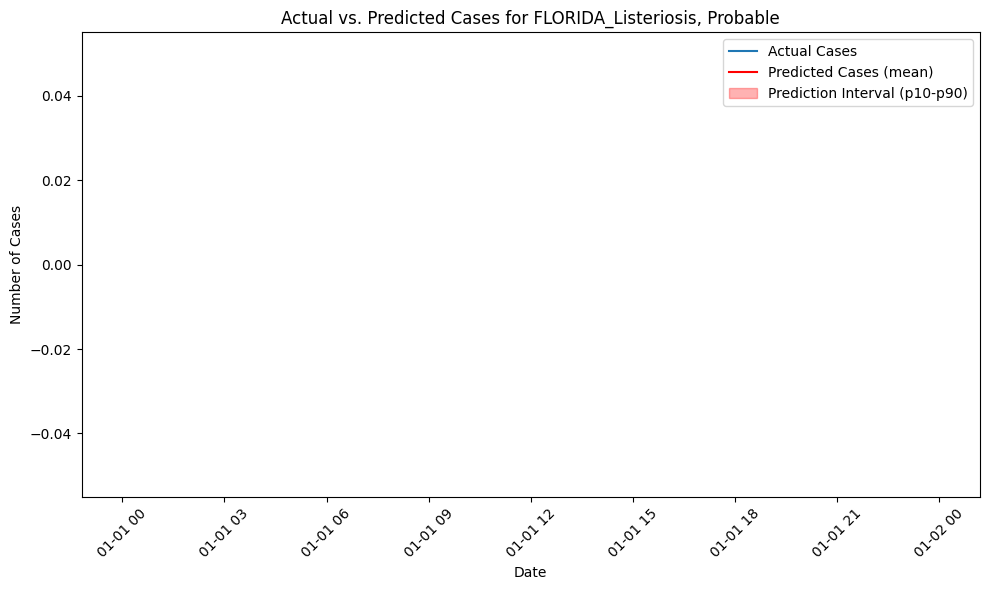

In [785]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(original_filtered['date'], original_filtered['new_cases'], label='Actual Cases')

# Plot the predicted mean
plt.plot(predictions_filtered['date'], predictions_filtered['pred_mean'], label='Predicted Cases (mean)', color='red')

# Plot prediction intervals
plt.fill_between(predictions_filtered['date'], predictions_filtered['pred_p10'], predictions_filtered['pred_p90'], color='red', alpha=0.3, label='Prediction Interval (p10-p90)')

plt.title(f"Actual vs. Predicted Cases for {selected_item_id}")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


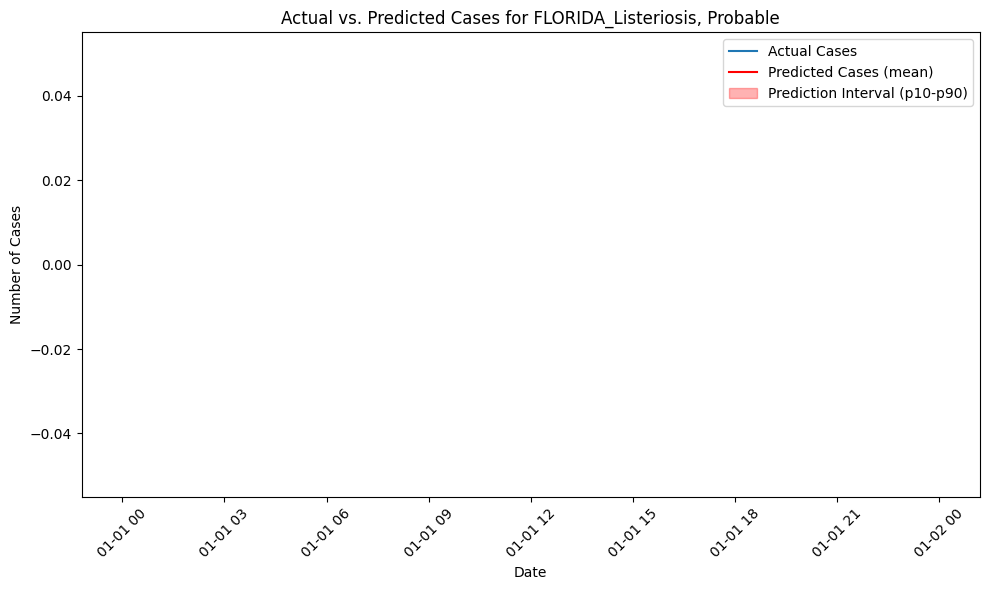

In [786]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(original_filtered['date'], original_filtered['new_cases'], label='Actual Cases')

# Plot the predicted mean
plt.plot(predictions_filtered['date'], predictions_filtered['pred_mean'], label='Predicted Cases (mean)', color='red')

# Plot prediction intervals
plt.fill_between(predictions_filtered['date'], predictions_filtered['pred_p10'], predictions_filtered['pred_p90'], color='red', alpha=0.3, label='Prediction Interval (p10-p90)')

plt.title(f"Actual vs. Predicted Cases for {selected_item_id}")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [787]:
import random

def plot_forecasts(df, all_preds_df, num_charts=5):
    """
    Plot forecasts for a random selection of item_ids.
    
    Parameters:
    - df: Original DataFrame with actual values.
    - all_preds_df: DataFrame with predictions.
    - num_charts: Number of charts to generate.
    """
    plt.figure(figsize=(15, num_charts * 3))
    
    # Select random item_ids
    random_item_ids = random.sample(list(df['item_id'].unique()), num_charts)
    
    for i, item_id in enumerate(random_item_ids, 1):
        plt.subplot(num_charts, 1, i)
        
        original_filtered = df[df['item_id'] == item_id]
        predictions_filtered = all_preds_df[all_preds_df['item_id'] == item_id]
        
        # Plot the actual values
        plt.plot(original_filtered['date'], original_filtered['new_cases'], label='Actual Cases')
        
        # Plot the predicted mean
        plt.plot(predictions_filtered['date'], predictions_filtered['pred_mean'], label='Predicted Cases (mean)', color='red')
        
        # Plot prediction intervals
        plt.fill_between(predictions_filtered['date'], predictions_filtered['pred_p10'], predictions_filtered['pred_p90'], color='red', alpha=0.3, label='Prediction Interval (p10-p90)')
        
        plt.title(f"Actual vs. Predicted Cases for {item_id}")
        plt.xlabel("Date")
        plt.ylabel("Number of Cases")
        plt.legend()
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Assuming `df` and `all_preds_df` are defined and contain the necessary data
# plot_forecasts(df, all_preds_df, num_charts=3) # Uncomment to run with your data


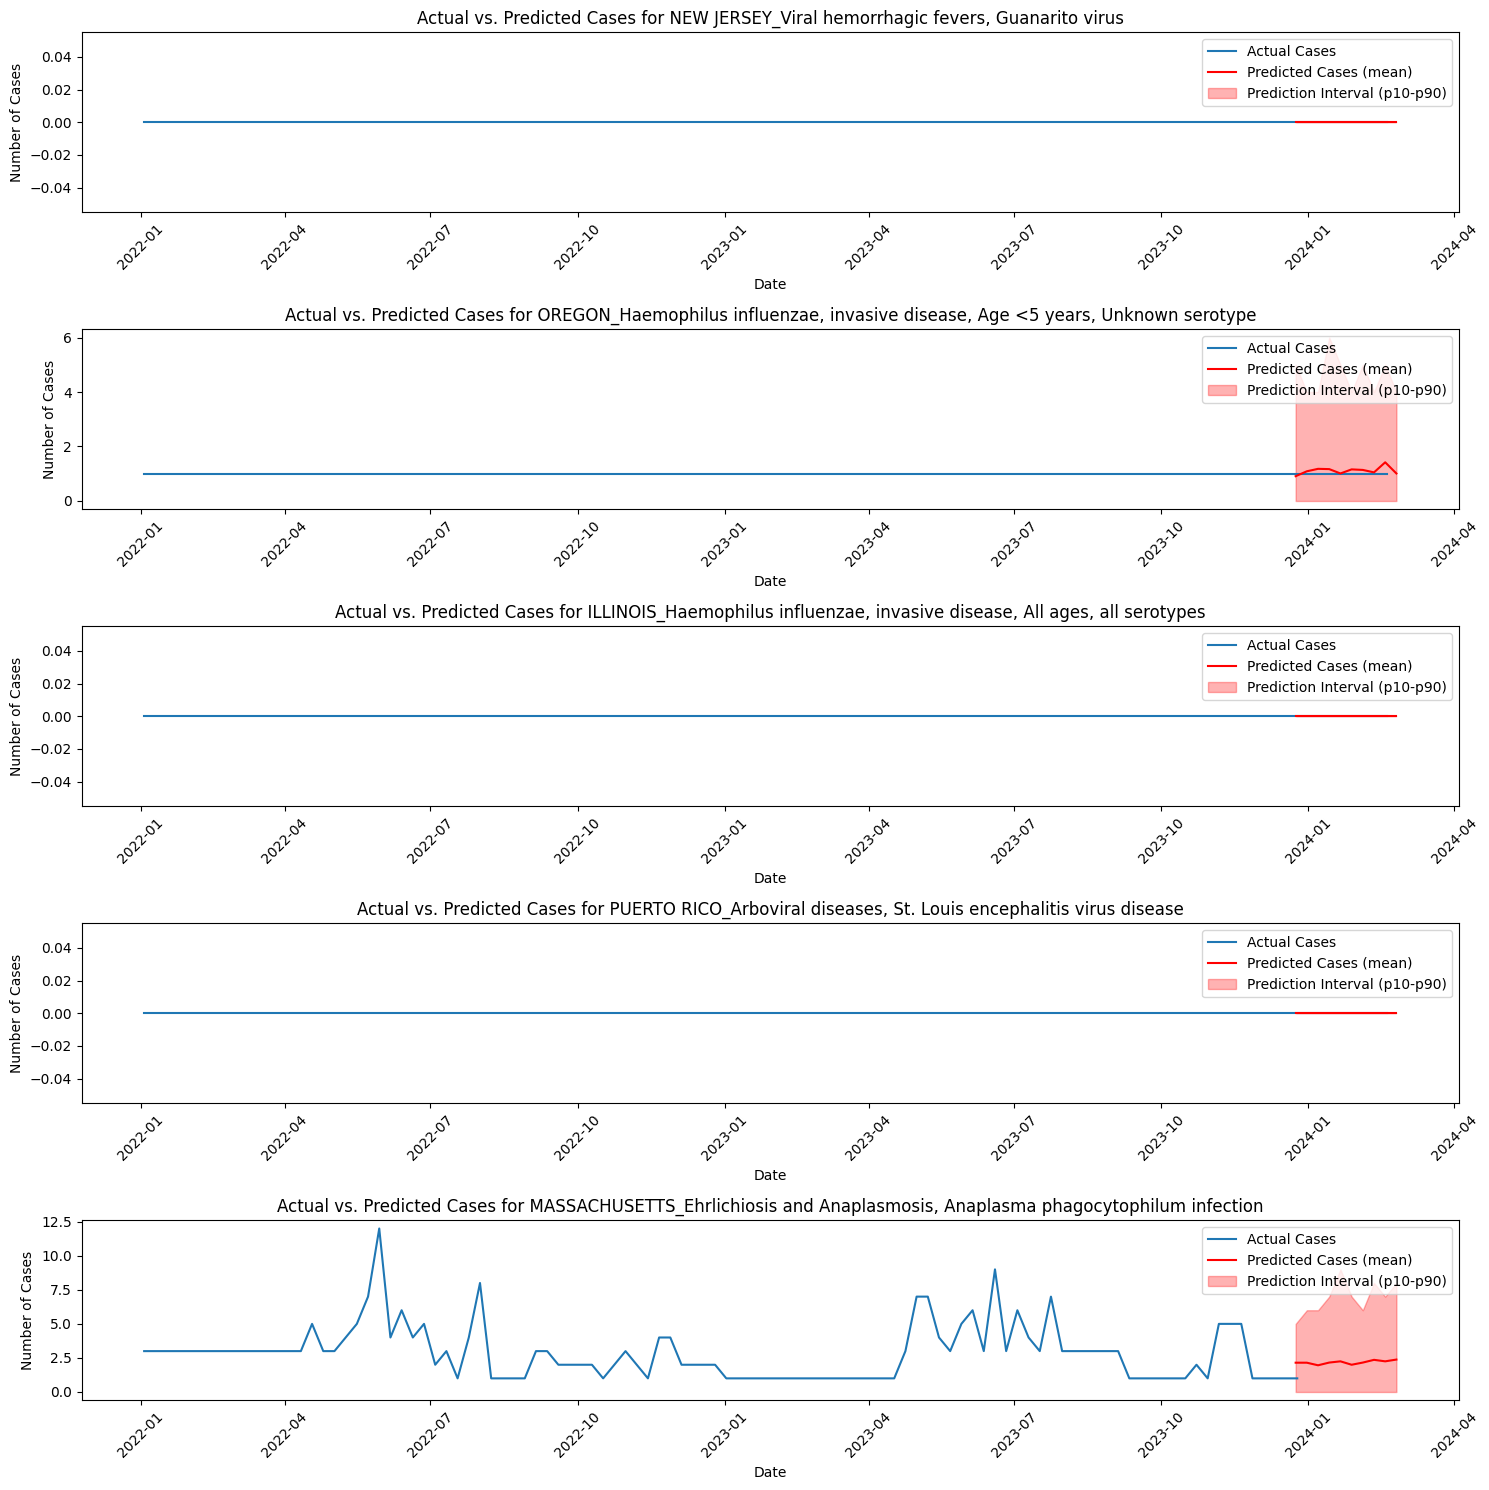

In [788]:
plot_forecasts(df, all_preds_df, num_charts=5)

In [793]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts(df, all_preds_df, num_charts=4):
    item_ids = np.random.choice(df['item_id'].unique(), size=num_charts, replace=False)
    
    num_rows = num_charts // 2 + num_charts % 2
    fig_width = 15  # Width of the entire figure
    fig_height_per_row = 3  # Height per row of charts
    fig, axes = plt.subplots(num_rows, 2, figsize=(fig_width, num_rows * fig_height_per_row))
    
    # Flatten the axes array for easy indexing, in case of a single row it needs adjustment
    axes = axes.flatten() if num_charts > 2 else [axes]
    
    for i, item_id in enumerate(item_ids):
        if i >= len(axes):  # Prevents indexing error if num_charts is odd
            break
        
        original_filtered = df[df['item_id'] == item_id]
        predictions_filtered = all_preds_df[all_preds_df['item_id'] == item_id]

        # Plot the actual values
        axes[i].plot(original_filtered['date'], original_filtered['new_cases'], label='Actual Cases')

        # Plot the predicted mean
        axes[i].plot(predictions_filtered['date'], predictions_filtered['pred_mean'], label='Predicted Cases (mean)', color='red')

        # Plot prediction intervals
        axes[i].fill_between(predictions_filtered['date'], predictions_filtered['pred_p10'], predictions_filtered['pred_p90'], color='red', alpha=0.3, label='Prediction Interval (p01-p99)')

        axes[i].set_title(f"{item_id}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Number of New Cases")
        axes[i].legend()
        axes[i].tick_params(axis='x', rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


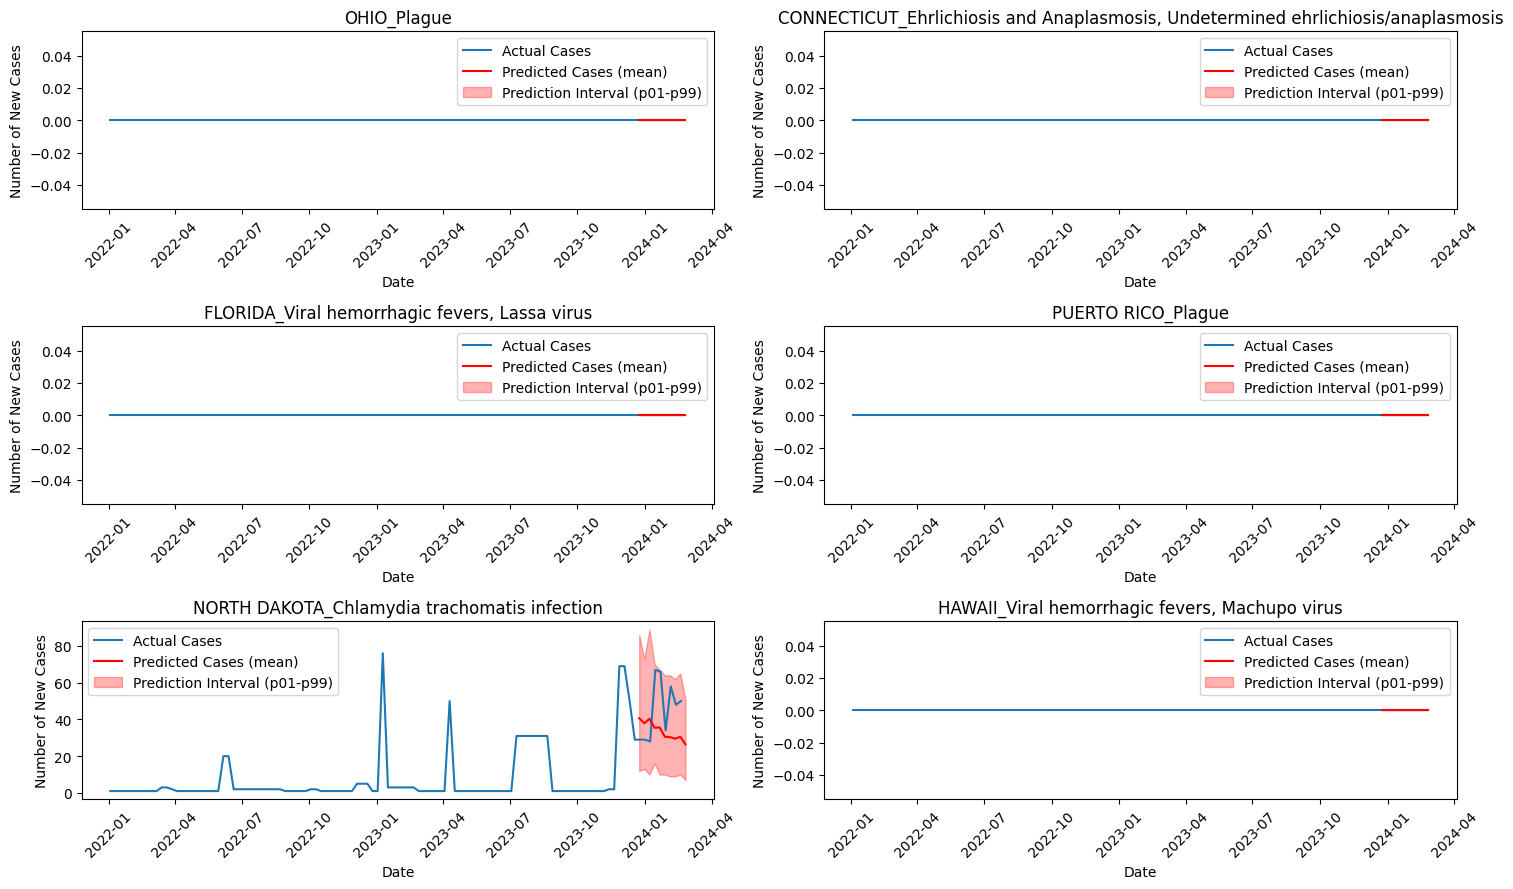

In [809]:
plot_forecasts(df, all_preds_df, num_charts=6)

In [843]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def plot_forecasts_plotly(df, all_preds_df, num_charts=4):
    item_ids = np.random.choice(df['item_id'].unique(), size=num_charts, replace=False)
    
    num_rows = num_charts // 2 + num_charts % 2
    fig = make_subplots(rows=num_rows, cols=2, subplot_titles=item_ids)
    
    for i, item_id in enumerate(item_ids, start=1):
        original_filtered = df[df['item_id'] == item_id]
        predictions_filtered = all_preds_df[all_preds_df['item_id'] == item_id]

        row = (i-1) // 2 + 1
        col = i % 2 if i % 2 != 0 else 2

        # Plot the actual values with lines
        fig.add_trace(go.Scatter(x=original_filtered['date'], y=original_filtered['new_cases'],
                                 mode='lines+markers', name=f'Actual {item_id}',
                                 legendgroup=f"group{i}", showlegend=False,
                                 line=dict(color='blue'),  # Set the line color to blue
                                 marker=dict(color=original_filtered['filled_value'].map({True: 'green', False: 'blue'}),  # Color dots based on filled_value
                                             size=2)),  # Set marker size
                      row=row, col=col)

        # Plot the predicted mean
        fig.add_trace(go.Scatter(x=predictions_filtered['date'], y=predictions_filtered['pred_mean'],
                                 mode='lines', name=f'Predicted {item_id}',
                                 legendgroup=f"group{i}", showlegend=False, line=dict(color='red')),
                      row=row, col=col)

        # Prediction intervals
        fig.add_trace(go.Scatter(x=predictions_filtered['date'], y=predictions_filtered['pred_p10'],
                                 mode='lines', name=f'Lower {item_id}', 
                                 legendgroup=f"group{i}", showlegend=False, line=dict(width=0)),
                      row=row, col=col)

        fig.add_trace(go.Scatter(x=predictions_filtered['date'], y=predictions_filtered['pred_p90'],
                                 mode='lines', name=f'Upper {item_id}', fill='tonexty',
                                 legendgroup=f"group{i}", showlegend=False, line=dict(width=0), fillcolor='rgba(255, 0, 0, 0.3)'),
                      row=row, col=col)
        
    fig.update_layout(template="plotly_dark", height=300*num_rows, title_text="Forecasts of New Cases", showlegend=False)
    fig.show()


In [845]:
plot_forecasts_plotly(df, all_preds_df, num_charts=8)

In [838]:
df.head()

,item_id,year,week,state,label,new_cases,date,filled_value
0,ALABAMA_Anthrax,2022,1,ALABAMA,Anthrax,0,2022-01-03,False
1,ALABAMA_Anthrax,2022,2,ALABAMA,Anthrax,0,2022-01-10,False
2,ALABAMA_Anthrax,2022,3,ALABAMA,Anthrax,0,2022-01-17,False
3,ALABAMA_Anthrax,2022,4,ALABAMA,Anthrax,0,2022-01-24,False
4,ALABAMA_Anthrax,2022,5,ALABAMA,Anthrax,0,2022-01-31,False
